In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import *
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from scipy import stats

import pandas as pd
import numpy as np

In [88]:
train_df = pd.read_csv("data/public_train_trx.csv")
test_df = pd.read_csv("data/public_test_trx.csv")
alldf = pd.concat([train_df,test_df])
alldf = alldf.sort_values(['session_id','duration_of_session','click_num'])
alldf = alldf.reset_index(drop=True)
target = 'TARGET_successful_purchase'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


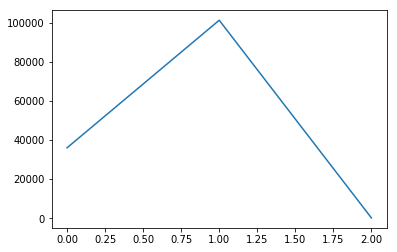

In [89]:
plt.plot(alldf.groupby('regio_of_customer',as_index=False).agg({target:'count'})['TARGET_successful_purchase'])

In [90]:
def columns_to_onehot(columnes_to_onehot, data):
    for column in columnes_to_onehot:
        one_hot = pd.get_dummies(data[column])
        one_hot.columns = one_hot.columns.map(str)
        one_hot.columns = one_hot.columns + '_' + column
        data = data.drop(column, axis=1)
        data = data.join(one_hot)
    return data

alldf = columns_to_onehot(['regio_of_customer'], alldf)

In [91]:
alldf['start_time_of_session_day_of_year'] = pd.to_datetime(alldf.start_date_of_session).dt.dayofyear
alldf['start_weekday_of_session'] = pd.to_datetime(alldf.start_date_of_session).dt.weekday
alldf['start_time_of_session_hour'] = pd.to_datetime(alldf.start_time_of_session).dt.hour
alldf['start_time_of_session_early'] = alldf['start_time_of_session_hour'] < 8

In [92]:
alldf = alldf.fillna(0)
# alldf['lifetime_customer_account'] = alldf['lifetime_customer_account'].replace(-1, 0)
aggregalando_valtozok = list(alldf.columns)
aggregalando_valtozok.remove('test_or_train_flag')
aggregalando_valtozok.remove(target)
aggregalando_valtozok.remove('start_date_of_session')
aggregalando_valtozok.remove('start_time_of_session')
aggregalando_valtozok.remove('session_id')

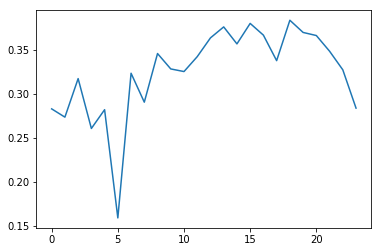

In [93]:
plt.plot(alldf.groupby('start_time_of_session_hour',as_index=False).agg({target:'mean'})['TARGET_successful_purchase'])

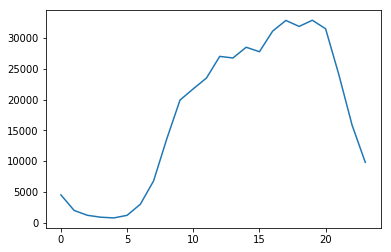

In [94]:
plt.plot(alldf.groupby('start_time_of_session_hour',as_index=False).agg({target:'count'})['TARGET_successful_purchase'])

In [124]:
agg.index

Int64Index([0, 1], dtype='int64')

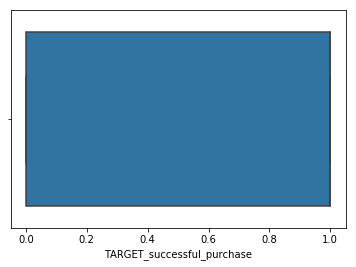

Error: TARGET_successful_purchase


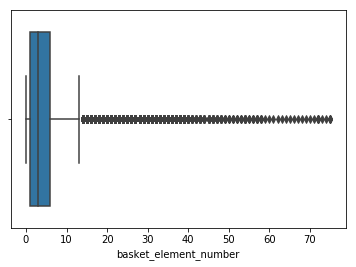

Error: basket_element_number


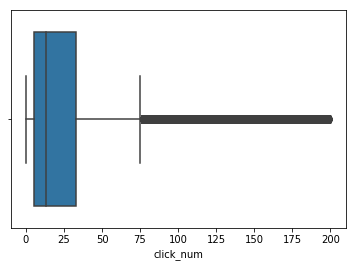

Error: click_num


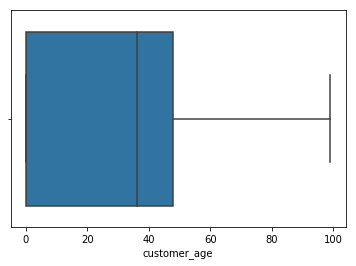

Error: customer_age


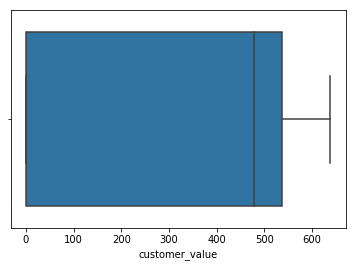

Error: customer_value


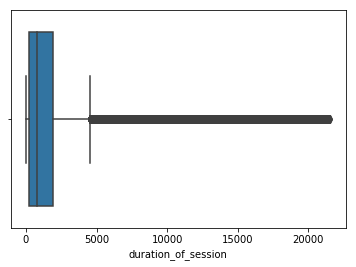

Error: duration_of_session


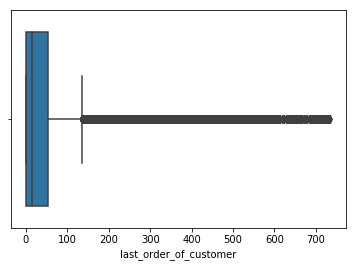

Error: last_order_of_customer


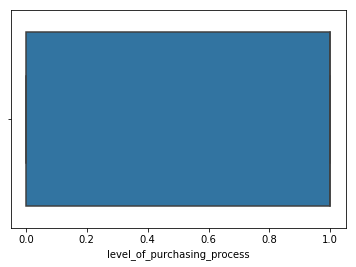

Error: level_of_purchasing_process


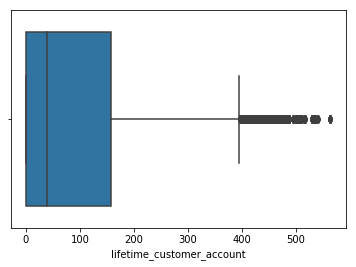

Error: lifetime_customer_account


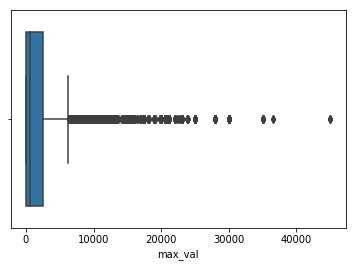

Error: max_val


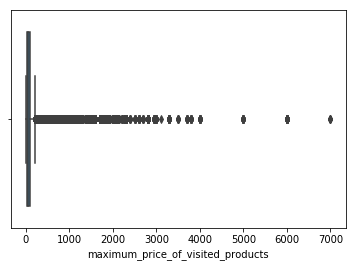

Error: maximum_price_of_visited_products


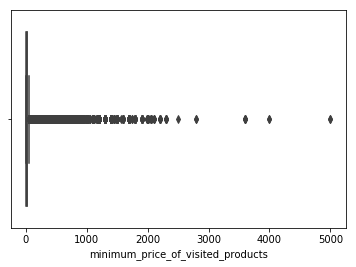

Error: minimum_price_of_visited_products


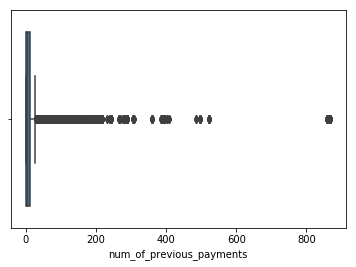

Error: num_of_previous_payments


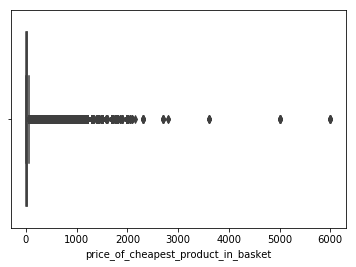

Error: price_of_cheapest_product_in_basket


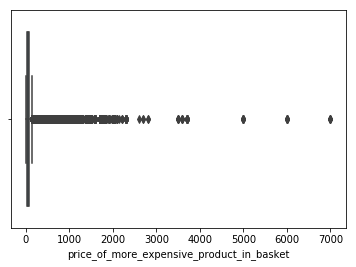

Error: price_of_more_expensive_product_in_basket
Error: session_id
Error: start_date_of_session
Error: start_time_of_session


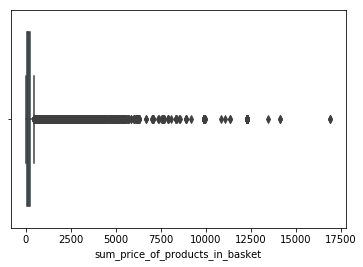

Error: sum_price_of_products_in_basket


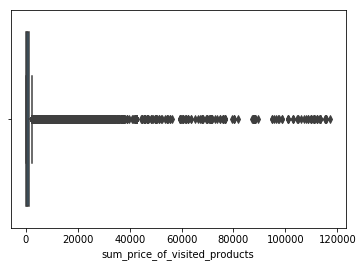

Error: sum_price_of_visited_products


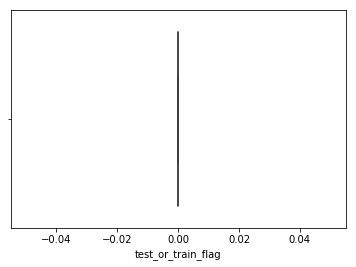

Error: test_or_train_flag


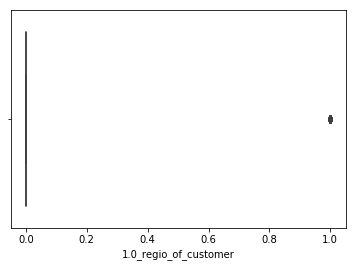

Error: 1.0_regio_of_customer


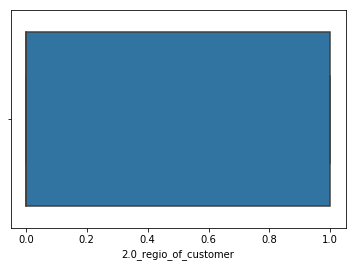

Error: 2.0_regio_of_customer


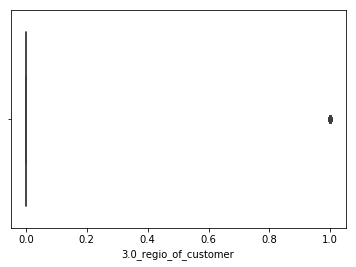

Error: 3.0_regio_of_customer


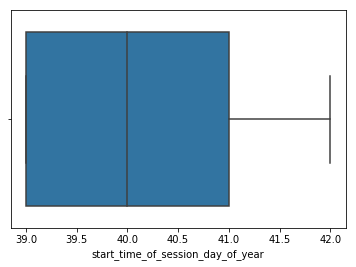

Error: start_time_of_session_day_of_year


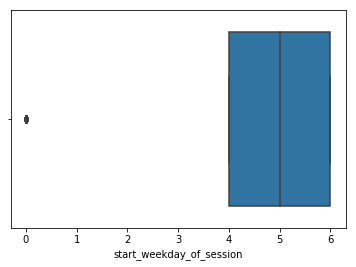

Error: start_weekday_of_session


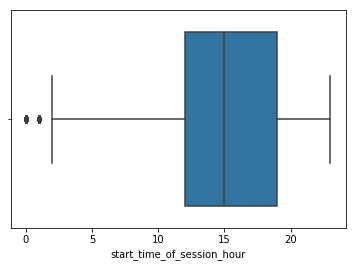

Error: start_time_of_session_hour


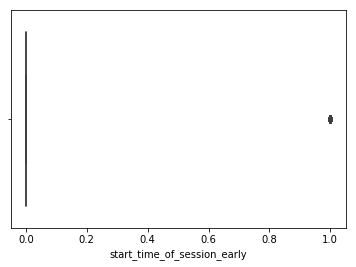

Error: start_time_of_session_early


In [122]:
import seaborn as sns
Q1 = alldf.quantile(0.25)
Q3 = alldf.quantile(0.75)
IQR = Q3 - Q1
box_top = Q3 + 1.5 * IQR
for column in alldf.columns:
    try:
        sns.boxplot(x=alldf[alldf['test_or_train_flag']==0][column])
        plt.show()
        agg = alldf.groupby(column,as_index=False).agg({target:'mean'})['TARGET_successful_purchase']
        plt.scatter(agg)
        plt.show()
#         break
        plt.plot(agg[:int(box_top[column])])
        plt.show()
        print(box_top[column])
        break
    except:
        print(f'Error: {column}')

In [118]:
int(box_top[column])

13

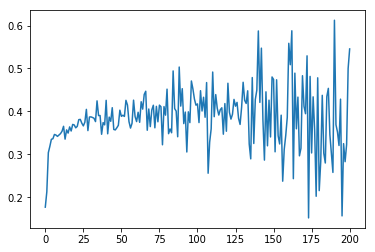

In [95]:
alldf.groupby('start_time_of_session_hour',as_index=False).agg({target:'mean'})['TARGET_successful_purchase']

0     0.283010
1     0.273609
2     0.317447
3     0.260718
4     0.282086
5     0.158974
6     0.323549
7     0.290643
8     0.345948
9     0.328446
10    0.325468
11    0.342411
12    0.363781
13    0.376256
14    0.356930
15    0.380229
16    0.366884
17    0.337877
18    0.383834
19    0.369962
20    0.366440
21    0.348608
22    0.327448
23    0.283875
Name: TARGET_successful_purchase, dtype: float64

In [96]:
cust_df = alldf.groupby('session_id',as_index=False).agg({target:'min',
                                        'test_or_train_flag':'min'})
for aggregalos_modszer in ['min','max', 'mean']:
    task={}
    ujoszlonevek=[]
    for v in aggregalando_valtozok:
        task[v]=aggregalos_modszer
        ujoszlonevek.append(aggregalos_modszer+"_"+v)
    stat = alldf.groupby(['session_id'],as_index=False).agg(task)
    stat.columns=['session_id']+ujoszlonevek
    cust_df = cust_df.merge(stat,on='session_id',how='left')

In [97]:
cust_df['click_per_durr'] = cust_df['max_click_num'] / cust_df['max_duration_of_session']
cust_df['vis_price_per_durr'] = cust_df['max_sum_price_of_visited_products'] / cust_df['max_duration_of_session']
cust_df['basket_elem_per_durr'] = cust_df['max_basket_element_number'] / cust_df['max_duration_of_session']
cust_df['basket_sum_per_durr'] = cust_df['max_sum_price_of_products_in_basket'] / cust_df['max_duration_of_session']

cust_df['bought_elem_visited_price_ratio'] = cust_df['max_basket_element_number'] / cust_df['max_sum_price_of_visited_products']

cust_df['bought_price_visited_price_ratio'] = cust_df['max_sum_price_of_products_in_basket']  / cust_df['max_sum_price_of_visited_products']

cust_df['payment_per_cust_existance'] = cust_df['max_num_of_previous_payments'] / cust_df['max_lifetime_customer_account']

cust_df['max_registration_age'] = cust_df['max_customer_age'] - (cust_df['max_lifetime_customer_account'] / 365)

cust_df.replace(np.inf, 0, inplace=True)
cust_df.fillna(0, inplace=True)

In [99]:
cust_df

,session_id,TARGET_successful_purchase,test_or_train_flag,min_basket_element_number,min_click_num,min_customer_age,min_customer_value,min_duration_of_session,min_last_order_of_customer,min_level_of_purchasing_process,...,mean_start_time_of_session_hour,mean_start_time_of_session_early,click_per_durr,vis_price_per_durr,basket_elem_per_durr,basket_sum_per_durr,bought_elem_visited_price_ratio,bought_price_visited_price_ratio,payment_per_cust_existance,max_registration_age
0,exxxxxshop.si-0.00021101047198248773,0.0,1,1,1,0.0,0.0,0.000,0.0,0.0,...,10,False,0.020339,1.016760,0.020339,1.016760,0.020004,1.000000,0.000000,0.000000
1,exxxxxshop.si-0.0002712991769484001,0.0,1,1,2,42.0,491.0,110.492,64.0,0.0,...,10,False,0.010403,0.233953,0.007802,0.181966,0.033348,0.777790,0.009804,41.441096
2,exxxxxshop.si-0.00033158788092821383,0.0,1,1,15,31.0,548.0,181.904,42.0,0.0,...,11,False,0.030286,0.838000,0.006057,0.128111,0.007228,0.152877,0.088889,30.876712
3,exxxxxshop.si-0.00039187658370279567,0.0,1,1,7,35.0,504.0,960.382,15.0,0.0,...,11,False,0.008836,0.091736,0.000680,0.027180,0.007409,0.296288,0.086957,34.621918
4,exxxxxshop.si-0.0004521652850530127,0.0,1,1,46,0.0,0.0,791.726,0.0,0.0,...,12,False,0.044047,1.627567,0.003146,0.125817,0.001933,0.077304,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49081,exxxxxshop.si0.9999999953977037,0.0,1,1,38,36.0,529.0,428.344,76.0,0.0,...,21,False,0.032355,0.102948,0.000840,0.004202,0.008163,0.040816,0.070175,35.843836
49082,exxxxxshop.si0.9999999963938254,0.0,1,1,1,0.0,0.0,0.000,0.0,0.0,...,19,False,0.000000,0.000000,0.000000,0.000000,0.143062,1.000000,0.000000,0.000000
49083,exxxxxshop.si0.9999999993644724,0.0,1,1,16,48.0,526.0,338.492,70.0,0.0,...,20,False,0.017776,0.571913,0.000820,0.023237,0.001435,0.040630,0.045249,47.394521
49084,exxxxxshop.si0.999999999696513,0.0,1,1,1,0.0,0.0,0.000,0.0,0.0,...,20,False,0.000000,0.000000,0.000000,0.000000,0.006689,1.000000,0.000000,0.000000


In [101]:
Q1 = cust_df.quantile(0.25)
Q3 = cust_df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
iqr_too_small = (cust_df < (Q1 - 1.5 * IQR))
iqr_too_large = (cust_df > (Q3 + 1.5 * IQR))
iqr_mask = iqr_too_large | iqr_too_small
np.mean(np.sum(iqr_mask, axis=1) > 0)

cust_df[iqr_too_large] = (cust_df > (Q3 + 1.5 * IQR))
# (Q1 - 1.5 * IQR)[iqr_too_small]

TARGET_successful_purchase           1.000000
test_or_train_flag                   1.000000
min_basket_element_number            0.000000
min_click_num                        5.000000
min_customer_age                    46.000000
                                      ...    
basket_sum_per_durr                  0.275142
bought_elem_visited_price_ratio      0.016165
bought_price_visited_price_ratio     0.371045
payment_per_cust_existance           0.083942
max_registration_age                45.967123
Length: 79, dtype: float64


TypeError: Cannot do inplace boolean setting on mixed-types with a non np.nan value

In [86]:
IQR.shape

(79,)

In [65]:
bemeno_valtozok = list(cust_df.columns)[3:]
bemeno_valtozok

['min_basket_element_number',
 'min_click_num',
 'min_customer_age',
 'min_customer_value',
 'min_duration_of_session',
 'min_last_order_of_customer',
 'min_level_of_purchasing_process',
 'min_lifetime_customer_account',
 'min_max_val',
 'min_maximum_price_of_visited_products',
 'min_minimum_price_of_visited_products',
 'min_num_of_previous_payments',
 'min_price_of_cheapest_product_in_basket',
 'min_price_of_more_expensive_product_in_basket',
 'min_sum_price_of_products_in_basket',
 'min_sum_price_of_visited_products',
 'min_1.0_regio_of_customer',
 'min_2.0_regio_of_customer',
 'min_3.0_regio_of_customer',
 'min_start_time_of_session_day_of_year',
 'min_start_weekday_of_session',
 'min_start_time_of_session_hour',
 'min_start_time_of_session_early',
 'max_basket_element_number',
 'max_click_num',
 'max_customer_age',
 'max_customer_value',
 'max_duration_of_session',
 'max_last_order_of_customer',
 'max_level_of_purchasing_process',
 'max_lifetime_customer_account',
 'max_max_val',
 

In [66]:
from sklearn.preprocessing import PolynomialFeatures


ismert_df = cust_df[ cust_df['test_or_train_flag']==0].copy()
# x_train = ismert_df[bemeno_valtozok]
# y_train = ismert_df[target]
# x_pred = cust_df[cust_df['test_or_train_flag'] == 1][bemeno_valtozok]

# poly = PolynomialFeatures(2)
# x_train = poly.fit_transform(x_train.to_numpy())
# x_pred = poly.transform(x_pred.to_numpy())

# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_pred = scaler.transform(x_pred)
# print(f"Training set size: {x_train.shape}")

In [67]:
ismert_df.groupby(['TARGET_successful_purchase']).agg({target:'count'})

,TARGET_successful_purchase
TARGET_successful_purchase,
0.0,11883
1.0,12701


In [74]:
def remove_ol(df, input_columns):
    z = np.abs(stats.zscore(df[input_columns].values.astype(float)))
    ol_mask = ~(np.sum(z > 3, axis=1) > 0)
    print(f'Outlier ratio: {1 - np.mean(ol_mask)}')
    return ol_mask

def rounding_score_decorator(score):
    return lambda y_true, y_pred: score(y_true, y_pred > 0.5)

def text2score(optimalization):
    if optimalization == 'AUC':
        score = roc_auc_score
    elif optimalization == 'Precision':
        score = rounding_score_decorator(precision_score)
    elif optimalization == 'Recall':
        score = rounding_score_decorator(recall_score)
    elif optimalization == 'Accuracy':
        score = rounding_score_decorator(accuracy_score)
    return score

def modell_evaluator(data, input_attributes, target_attribute, model, n=1):
    def test_attributes(fix_input, possible_inputs):
        best_score = -1
        best_input = None
        for possible_input in possible_inputs:
            current_input = fix_input + [possible_input]
            ol_mask = remove_ol(data, current_input)
            x_train = data[ol_mask][current_input].values
#             x_train = data[fix_input + [possible_input]].to_numpy()
#             poly = PolynomialFeatures(n)
#             x_train = poly.fit_transform(x_train)
#             scaler = StandardScaler()
#             x_train = scaler.fit_transform(x_train)
            cv_results = cross_validate(model,
                            x_train, data[ol_mask][target_attribute].values,
                            scoring=['roc_auc', 'accuracy'], cv=3, n_jobs=4)
            s = cv_results['test_roc_auc'].mean()
            if s > best_score:
                best_score = s
                best_input = possible_input
        return best_input, best_score
    good_inputs = []
    in_race_inputs = input_attributes
    best_s = -1
    while len(in_race_inputs):
        i_to_accept, s = test_attributes(good_inputs, input_attributes)
        print(i_to_accept, s)
        if s < best_s:
            return best_s, good_inputs
        
        best_s = s
        good_inputs.append(i_to_accept)
        in_race_inputs.remove(i_to_accept)
    return best_s, good_inputs

In [75]:
from sklearn.linear_model import LogisticRegression
modell_evaluator(ismert_df, 
                 bemeno_valtozok, 
                 target,
                 LogisticRegression())

Outlier ratio: 0.012894565571103134
Outlier ratio: 0.019565571103156487
Outlier ratio: 0.00020338431500166454
Outlier ratio: 0.0
Outlier ratio: 0.01797917344614386
Outlier ratio: 0.030711031565245683
Outlier ratio: 0.005816791409046562
Outlier ratio: 0.012121705174096942
Outlier ratio: 0.023592580540188757
Outlier ratio: 0.02135535307517089
Outlier ratio: 0.026684022128213525
Outlier ratio: 0.011714936544093724
Outlier ratio: 0.025504393101204004
Outlier ratio: 0.023511226814188046
Outlier ratio: 0.023511226814188046
Outlier ratio: 0.011633582818093013
Outlier ratio: 0.0
Outlier ratio: 0.0
Outlier ratio: 0.0004881223560039283
Outlier ratio: 0.0
Outlier ratio: 0.012203058900097652
Outlier ratio: 0.0
Outlier ratio: 0.06630328669053043
Outlier ratio: 0.021029938171168272
Outlier ratio: 0.025423039375203405
Outlier ratio: 0.00020338431500166454
Outlier ratio: 0.0
Outlier ratio: 0.022087536609176728
Outlier ratio: 0.03075170842824604
Outlier ratio: 0.0
Outlier ratio: 0.012203058900097652
Ou

Outlier ratio: 0.06618125610152947
Outlier ratio: 0.0546697038724373
Outlier ratio: 0.043239505369345954
Outlier ratio: 0.043239505369345954
Outlier ratio: 0.04372762772534977
Outlier ratio: 0.043239505369345954
Outlier ratio: 0.05523917995444194
Outlier ratio: 0.043239505369345954
Outlier ratio: 0.10787504067686304
Outlier ratio: 0.0461682395053693
Outlier ratio: 0.061910185486495295
Outlier ratio: 0.04344288968434751
Outlier ratio: 0.043239505369345954
Outlier ratio: 0.06211356980149696
Outlier ratio: 0.07313699967458509
Outlier ratio: 0.05320533680442563
Outlier ratio: 0.04332085909534655
Outlier ratio: 0.06154409371949232
Outlier ratio: 0.06695411649853567
Outlier ratio: 0.04808005206638466
Outlier ratio: 0.06618125610152947
Outlier ratio: 0.06719817767653757
Outlier ratio: 0.057720468597461716
Outlier ratio: 0.056540839570452306
Outlier ratio: 0.043239505369345954
Outlier ratio: 0.043239505369345954
Outlier ratio: 0.04372762772534977
Outlier ratio: 0.043239505369345954
Outlier rat

Outlier ratio: 0.046371623820370966
Outlier ratio: 0.064879596485519
Outlier ratio: 0.07614708753660915
Outlier ratio: 0.05633745525545075
Outlier ratio: 0.04645297754637168
Outlier ratio: 0.06463553530751709
Outlier ratio: 0.07008623494956068
Outlier ratio: 0.05113081679140907
Outlier ratio: 0.06931337455255449
Outlier ratio: 0.07028961926456234
Outlier ratio: 0.060811910185486484
Outlier ratio: 0.05959160429547672
Outlier ratio: 0.046371623820370966
Outlier ratio: 0.046371623820370966
Outlier ratio: 0.046859746176374895
Outlier ratio: 0.046371623820370966
Outlier ratio: 0.058371298405466954
Outlier ratio: 0.046371623820370966
Outlier ratio: 0.11092580540188746
Outlier ratio: 0.06561178001952495
Outlier ratio: 0.046371623820370966
Outlier ratio: 0.046371623820370966
Outlier ratio: 0.06553042629352424
Outlier ratio: 0.07614708753660915
Outlier ratio: 0.0562967783924504
Outlier ratio: 0.06837780670354698
Outlier ratio: 0.07325903026358604
Outlier ratio: 0.05113081679140907
Outlier ratio

Outlier ratio: 0.10478359908883828
Outlier ratio: 0.10563781321184507
Outlier ratio: 0.11365115522290925
Outlier ratio: 0.0997396680767979
Outlier ratio: 0.11055971363488448
Outlier ratio: 0.10592255125284733
Outlier ratio: 0.10136674259681089
Outlier ratio: 0.09522453628376182
Outlier ratio: 0.09522453628376182
Outlier ratio: 0.09567198177676539
Outlier ratio: 0.09522453628376182
Outlier ratio: 0.10653270419785221
Outlier ratio: 0.09522453628376182
Outlier ratio: 0.15571103156524568
Outlier ratio: 0.09550927432476408
Outlier ratio: 0.09546859746176373
Outlier ratio: 0.09550927432476408
Outlier ratio: 0.09546859746176373
Outlier ratio: 0.1289049788480312
Outlier ratio: 0.09522453628376182
Outlier ratio: 0.10311584770582494
min_last_order_of_customer 0.8733613675706092
Outlier ratio: 0.13329808005206634
Outlier ratio: 0.12349495606898797
Outlier ratio: 0.12349495606898797
Outlier ratio: 0.13659290595509277
Outlier ratio: 0.12349495606898797
Outlier ratio: 0.13285063455906276
Outlier rat

Outlier ratio: 0.14794175073218352
Outlier ratio: 0.15168402212821352
Outlier ratio: 0.14696550602017577
Outlier ratio: 0.14696550602017577
Outlier ratio: 0.14741295151317935
Outlier ratio: 0.14696550602017577
Outlier ratio: 0.1579889358932639
Outlier ratio: 0.14696550602017577
Outlier ratio: 0.2050113895216401
Outlier ratio: 0.14997559388219983
Outlier ratio: 0.14696550602017577
Outlier ratio: 0.14696550602017577
Outlier ratio: 0.14696550602017577
Outlier ratio: 0.1561178001952489
Outlier ratio: 0.14696550602017577
Outlier ratio: 0.1521314676212171
Outlier ratio: 0.15266026684022127
Outlier ratio: 0.1514399609502115
Outlier ratio: 0.14794175073218352
Outlier ratio: 0.14798242759518387
Outlier ratio: 0.1513586072242109
Outlier ratio: 0.14696550602017577
Outlier ratio: 0.14696550602017577
Outlier ratio: 0.14741295151317935
Outlier ratio: 0.14696550602017577
Outlier ratio: 0.1579889358932639
Outlier ratio: 0.14696550602017577
Outlier ratio: 0.2050113895216401
Outlier ratio: 0.14696550602

Outlier ratio: 0.21729580214773836
Outlier ratio: 0.16051090139928403
Outlier ratio: 0.1604702245362838
Outlier ratio: 0.16051090139928403
Outlier ratio: 0.1604702245362838
Outlier ratio: 0.193621867881549
Outlier ratio: 0.16787341360234298
min_click_num 0.8791708142829053
Outlier ratio: 0.1689716889033518
Outlier ratio: 0.17495118776439966
Outlier ratio: 0.1689716889033518
Outlier ratio: 0.17796127562642372
Outlier ratio: 0.1689716889033518
Outlier ratio: 0.1730393752033843
Outlier ratio: 0.16909371949235275
Outlier ratio: 0.17340546697038728
Outlier ratio: 0.1703953791083631
Outlier ratio: 0.16941913439635536
Outlier ratio: 0.16941913439635536
Outlier ratio: 0.1721851610803775
Outlier ratio: 0.1689716889033518
Outlier ratio: 0.1689716889033518
Outlier ratio: 0.16941913439635536
Outlier ratio: 0.1689716889033518
Outlier ratio: 0.17946631955743575
Outlier ratio: 0.1689716889033518
Outlier ratio: 0.2255125284738041
Outlier ratio: 0.1689716889033518
Outlier ratio: 0.1689716889033518
Outl

Outlier ratio: 0.1739749430523918
Outlier ratio: 0.2302717214448422
Outlier ratio: 0.17425968109339407
Outlier ratio: 0.17421900423039371
Outlier ratio: 0.17425968109339407
Outlier ratio: 0.17421900423039371
Outlier ratio: 0.20737064757565893
Outlier ratio: 0.18141880898145135
vis_price_per_durr 0.8806595146467502
Outlier ratio: 0.17421900423039371
Outlier ratio: 0.17995444191343968
Outlier ratio: 0.17421900423039371
Outlier ratio: 0.1831679140904653
Outlier ratio: 0.17421900423039371
Outlier ratio: 0.17434103481939478
Outlier ratio: 0.1785714285714286
Outlier ratio: 0.17543931012040348
Outlier ratio: 0.17454441913439633
Outlier ratio: 0.17454441913439633
Outlier ratio: 0.17617149365440932
Outlier ratio: 0.17421900423039371
Outlier ratio: 0.17421900423039371
Outlier ratio: 0.1746664497233973
Outlier ratio: 0.17421900423039371
Outlier ratio: 0.18471363488447767
Outlier ratio: 0.23047510575984376
Outlier ratio: 0.17421900423039371
Outlier ratio: 0.17421900423039371
Outlier ratio: 0.17421

(0.8806595146467502,
 ['max_level_of_purchasing_process',
  'mean_max_val',
  'mean_basket_element_number',
  'max_basket_element_number',
  'max_registration_age',
  'mean_level_of_purchasing_process',
  'mean_sum_price_of_products_in_basket',
  'mean_click_num',
  'min_basket_element_number',
  'min_last_order_of_customer',
  'min_customer_value',
  'max_price_of_more_expensive_product_in_basket',
  'max_duration_of_session',
  'max_click_num',
  'bought_price_visited_price_ratio',
  'mean_minimum_price_of_visited_products',
  'min_click_num',
  'min_start_time_of_session_hour',
  'min_maximum_price_of_visited_products',
  'max_minimum_price_of_visited_products',
  'vis_price_per_durr',
  'min_level_of_purchasing_process'])

In [ ]:
from sklearn.svm import SVC
modell_evaluator(ismert_df, 
                 bemeno_valtozok, 
                 target,
                 SVC())

In [ ]:
from sklearn.neighbors import *
modell_evaluator(ismert_df, 
                 bemeno_valtozok, 
                 target,
                 KNeighborsClassifier())

In [ ]:
from sklearn.tree import *
modell_evaluator(ismert_df, 
                 bemeno_valtozok, 
                 target,
                 DecisionTreeClassifier())

In [ ]:
cv_results = cross_validate(DecisionTreeClassifier(max_depth = 6),
                            x_train, y_train,
                            scoring=['roc_auc', 'accuracy'], cv=3, n_jobs=4)
auc = cv_results['test_roc_auc'].mean()
print(f"\t{auc},\t{cv_results['test_accuracy'].mean()}")

In [ ]:
model = RandomForestClassifier(max_depth = 14, n_estimators = 1000)
model.fit(x_train, y_train)
pred = model.predict_proba(x_pred)
# accuracy_score(ismert_df[target],model.predict(ismert_df[bemeno_valtozok]))